Elena Gillis
Assignment 1 - Pyspark
January 30, 2019

In [2]:
import pandas as pd
import pyspark

from os import listdir
from os.path import isfile, join
import boto3
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [3]:
# Create context:
# Initialize the spark environment (takes ~ 1min)
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [157]:
# Import data from S3
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'emg3sc/realestate.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)

# Create a dataframe
df = sqlc.createDataFrame(pd.read_csv(data_location))

In [154]:
# Convert to parquet
parquetPath = '/home/ec2-user/SageMaker/emg3sc-pqt4'
df.write.parquet(parquetPath)

In [155]:
# Write to Spark df from parquet
df = sqlc.read.parquet(parquetPath)
df

DataFrame[date: double, age: double, dist: double, store: bigint, lat: double, long: double, price: double]

In [156]:
# Print the schema of the dataframe
df.printSchema()

root
 |-- date: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dist: double (nullable = true)
 |-- store: long (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- price: double (nullable = true)



In [87]:
# Display five ramdom rows
df.take(5)

[Row(date=2012.917, age=32.0, dist=84.87882, store=10, lat=24.98298, long=121.54024, price=37.9),
 Row(date=2012.917, age=19.5, dist=306.5947, store=9, lat=24.98034, long=121.53951, price=42.2),
 Row(date=2013.583, age=13.3, dist=561.9845, store=5, lat=24.98746, long=121.54391, price=47.3),
 Row(date=2013.5, age=13.3, dist=561.9845, store=5, lat=24.98746, long=121.54391, price=54.8),
 Row(date=2012.833, age=5.0, dist=390.5684, store=5, lat=24.97937, long=121.54245, price=43.1)]

In [88]:
# Identify correlations
print("Pearson's r(price, age) = {}".format(df.corr("price", "age")))
print("Pearson's r(price, dist) = {}".format(df.corr("price", "dist")))
print("Pearson's r(price, store) = {}".format(df.corr("price", "store")))
print("Pearson's r(price, date) = {}".format(df.corr("price", "date")))
print("Pearson's r(price, lat) = {}".format(df.corr("price", "lat")))
print("Pearson's r(price, long) = {}".format(df.corr("price", "long")))

Pearson's r(price, age) = -0.21056704627721673
Pearson's r(price, dist) = -0.6736128553689182
Pearson's r(price, store) = 0.5710049111111479
Pearson's r(price, date) = 0.0874906064025099
Pearson's r(price, lat) = 0.5463066525036067
Pearson's r(price, long) = 0.5232865070288145


In [89]:
# Assemble features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["date", "age", "dist", "store", "lat", "long"],
    outputCol="features")

output = assembler.transform(df)
output.select("features", "price").show(truncate=False)

+------------------------------------------------+-----+
|features                                        |price|
+------------------------------------------------+-----+
|[2012.917,32.0,84.87882,10.0,24.98298,121.54024]|37.9 |
|[2012.917,19.5,306.5947,9.0,24.98034,121.53951] |42.2 |
|[2013.583,13.3,561.9845,5.0,24.98746,121.54391] |47.3 |
|[2013.5,13.3,561.9845,5.0,24.98746,121.54391]   |54.8 |
|[2012.833,5.0,390.5684,5.0,24.97937,121.54245]  |43.1 |
|[2012.667,7.1,2175.03,3.0,24.96305,121.51254]   |32.1 |
|[2012.667,34.5,623.4731,7.0,24.97933,121.53642] |40.3 |
|[2013.417,20.3,287.6025,6.0,24.98042,121.54228] |46.7 |
|[2013.5,31.7,5512.038,1.0,24.95095,121.48458]   |18.8 |
|[2013.417,17.9,1783.18,3.0,24.96731,121.51486]  |22.1 |
|[2013.083,34.8,405.2134,1.0,24.97349,121.53372] |41.4 |
|[2013.333,6.3,90.45606,9.0,24.97433,121.5431]   |58.1 |
|[2012.917,13.0,492.2313,5.0,24.96515,121.53737] |39.3 |
|[2012.667,20.4,2469.645,4.0,24.96108,121.51046] |23.8 |
|[2013.5,13.2,1164.838,4.0,24.9

In [90]:
# Select area and temp for analysis
df1 = output.select("price","features")

In [91]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df1.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 331, test set N = 83


In [92]:
# Vectorization
from pyspark.ml.linalg import Vectors, VectorUDT

# make a user defined function (udf) to convert multiple features to a dense vector
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense(d), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("price", "oneElementVec(features) as features")
testDF = testDF.selectExpr("price", "oneElementVec(features) as features")

print(testDF.orderBy(testDF.price.desc()).limit(5))

DataFrame[price: double, features: vector]


In [93]:
# rename variables for ML
trainingDF = trainingDF.withColumnRenamed("price", "label")
testDF = testDF.withColumnRenamed("price", "label")

In [98]:
from pyspark.ml.regression import RandomForestRegressor

# Train a Random Forest model
rf = RandomForestRegressor()
rfModel = rf.fit(trainingDF)

# transform test set to make predictions (predict on test set)
predictionsAndLabelsDF = rfModel.transform(testDF)

In [99]:
# evaluate model
from pyspark.ml.evaluation import RegressionEvaluator

eval = RegressionEvaluator()

# Root mean squared error
rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# r-squared
r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
print("R-squared = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 6.21435
R-squared = 0.74881


In [110]:
type(predictionsAndLabelsDF)

pyspark.sql.dataframe.DataFrame

In [113]:
pdf = predictionsAndLabelsDF.toPandas()
pdf.head()

,label,features,prediction
0,12.9,"[2012.75, 16.1, 4066.587, 0.0, 24.94297, 121.5...",17.592194
1,13.0,"[2013.0, 13.6, 4197.349, 0.0, 24.93885, 121.50...",17.701947
2,13.7,"[2012.833, 31.7, 1160.632, 0.0, 24.94968, 121....",21.079032
3,13.8,"[2012.917, 31.7, 1159.454, 0.0, 24.9496, 121.5...",21.079032
4,15.6,"[2013.333, 25.6, 4519.69, 0.0, 24.94826, 121.4...",17.010406


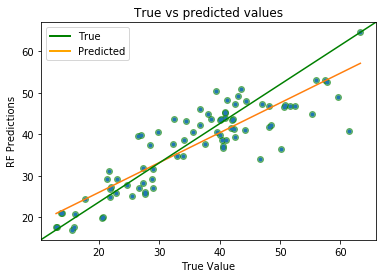

In [150]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.lines as mlines

true = pdf['label']
prediction = pdf['prediction']

fig, ax = plt.subplots()
plt.scatter(true, prediction, c="g", alpha=0.5)
plt.xlabel('True Value')
plt.ylabel('RF Predictions')
plt.title('True vs predicted values')

# Fit a line with with polyfit
b, m = polyfit(true, prediction, 1)
plt.plot(true, prediction, '.')
plt.plot(true, b + m * true, '-')

# Add a line for true values
line = mlines.Line2D([0, 1], [0, 1], c='g')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# Create a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
ax.legend(custom_lines, ['True','Predicted'])
plt.show()